<a href="https://colab.research.google.com/github/NickSotirakis/attMPTI/blob/main/berts_TF_echr_context.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install transformers

import json
import pandas as pd

import os

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint

import transformers
from transformers import TFAutoModel, AutoTokenizer, AutoConfig
from tqdm.notebook import tqdm
from tokenizers import Tokenizer, models, pre_tokenizers, decoders, processors

from fastai.text import *
from tensorflow.keras.layers import Dense, Input, Dropout, Flatten

from tensorflow import keras
from tensorflow.keras import layers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

f = open('/content/drive/My Drive/ECHR_Corpus.json')
echr = json.load(f)
len(echr)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


42

In [ ]:
args = []
all_clauses = []
for i in range(len(echr)):
  args.append(echr[i]['arguments'])
  all_clauses.extend(echr[i]["clauses"])
args[0][1]
len(all_clauses)

10456

In [ ]:
premises = []
for a in args:
  for d in a: 
    for id in d['premises']:
      premises.append(id)
print(len(premises))

1951


In [ ]:
conclusions = []
for a in args:
  for d in a:
    conclusions.append(d['conclusion'])
print(len(conclusions))

743


In [ ]:
num_clauses = len(all_clauses)
indices = np.random.choice(num_clauses, size=num_clauses, replace=False)
train_indices = indices[:int(0.9*num_clauses)]
test_indices = indices[int(0.9*num_clauses):]

test_ids=[]
for i in range(num_clauses):
  if i in test_indices:
    test_ids.append(all_clauses[i]["_id"])

len(test_ids)

1046

In [ ]:
big_dict = {'ID' : [], 'TEXT' : [],'SEQ_START' : [], 'SEQ_END' : []}
list_of_dicts = []
for i in range(len(echr)):
  txt = echr[i]['text']
  echr[i]['clauses'].sort(key=lambda x: x["start"])
  clauses = echr[i]['clauses']

  for i in range(len(clauses)):
    context=""
    for j in range(min(i,5),0,-1):
      
      if clauses[i-j]["_id"] not in test_ids: #what happens if current clause[i] is part of the test set?
        context += txt[clauses[i-j]["start"]:clauses[i-j]["end"]]
    
    clauses[i]["context"] = context

  d = {'ID':[d['_id'] for d in clauses], 'TEXT': [txt[d['start']:d['end']] for d in clauses],'SEQ_START': [d['start'] for d in clauses],'SEQ_END': [d['end'] for d in clauses], 'CONTEXT':[d["context"] for d in clauses]}
  list_of_dicts.append(d)


In [ ]:
dfs = pd.concat([pd.DataFrame(dfs) for dfs in list_of_dicts])

In [ ]:
dfs

,ID,TEXT,SEQ_START,SEQ_END,CONTEXT
0,5d3fbf383e582511aa1cc856,The European Commission of Human Rights sittin...,182,297,
1,5d3fbf3d3e582511aa1cc857,Having regard to Article 25 of the Convention ...,917,1023,The European Commission of Human Rights sittin...
2,5d3fbf413e582511aa1cc858,Having regard to the application introduced on...,1027,1179,The European Commission of Human Rights sittin...
3,5d3fbf443e582511aa1cc859,Having regard to:,1181,1198,The European Commission of Human Rights sittin...
4,5d3fbfa03e582511aa1cc85a,reports provided for in Rule 47 of the Rules o...,1208,1284,The European Commission of Human Rights sittin...
...,...,...,...,...,...
364,5f943e0bbf181507836fa258,I refer once more to my dissenting opinion ann...,74512,75024,For these reasons I find that there has been a...
365,5f943e35bf181507836fa259,I consider too that in the present case Mr Ahm...,75025,75561,In its report referred to in paragraph 4 of t...
366,5f943dfabf181507836fa257,In these accusations and in his conviction the...,75562,75916,that the Court cannot deal with the merits of ...
367,5f943d86bf181507836fa255,Article 27 of the Convention (art. 27) require...,75917,76264,that the Court cannot deal with the merits of ...


In [ ]:
dfs = dfs.reset_index(drop=True)

In [ ]:
dfs['IS_PREMISE'] = dfs.apply(lambda row: 1 if row.ID in premises else 0, axis=1)

In [ ]:
dfs['IS_CONCLUSION'] = dfs.apply(lambda row: 1 if row.ID in conclusions else 0, axis=1)

In [ ]:
dfs['LABEL'] = dfs.apply(lambda row: 1 if row.IS_PREMISE == 1 or row.IS_CONCLUSION ==1 else 0, axis=1)

In [ ]:
dfs

,ID,TEXT,SEQ_START,SEQ_END,CONTEXT,IS_PREMISE,IS_CONCLUSION,LABEL
0,5d3fbf383e582511aa1cc856,The European Commission of Human Rights sittin...,182,297,,0,0,0
1,5d3fbf3d3e582511aa1cc857,Having regard to Article 25 of the Convention ...,917,1023,The European Commission of Human Rights sittin...,0,0,0
2,5d3fbf413e582511aa1cc858,Having regard to the application introduced on...,1027,1179,The European Commission of Human Rights sittin...,0,0,0
3,5d3fbf443e582511aa1cc859,Having regard to:,1181,1198,The European Commission of Human Rights sittin...,0,0,0
4,5d3fbfa03e582511aa1cc85a,reports provided for in Rule 47 of the Rules o...,1208,1284,The European Commission of Human Rights sittin...,0,0,0
...,...,...,...,...,...,...,...,...
10451,5f943e0bbf181507836fa258,I refer once more to my dissenting opinion ann...,74512,75024,For these reasons I find that there has been a...,0,0,0
10452,5f943e35bf181507836fa259,I consider too that in the present case Mr Ahm...,75025,75561,In its report referred to in paragraph 4 of t...,0,0,0
10453,5f943dfabf181507836fa257,In these accusations and in his conviction the...,75562,75916,that the Court cannot deal with the merits of ...,0,0,0
10454,5f943d86bf181507836fa255,Article 27 of the Convention (art. 27) require...,75917,76264,that the Court cannot deal with the merits of ...,1,0,1


In [ ]:
import sklearn.utils

dfs_train = dfs[dfs.apply(lambda row: row.ID not in test_ids, axis=1)]
dfs_test = dfs[dfs["ID"].isin(test_ids)]
dfs_test = sklearn.utils.shuffle(dfs_test)
dfs_train = sklearn.utils.shuffle(dfs_train)

df_test = dfs_test[['TEXT','LABEL', 'CONTEXT']]

df_train = dfs_train[['TEXT','LABEL', 'CONTEXT']]

In [ ]:
print(len(df_train), len(df_test))

9410 1046


In [ ]:
"""arr = df_train[["TEXT","CONTEXT"]]
for i, r in arr.iterrows():
  if i<5:
    print([r["TEXT"], r["CONTEXT"]])"""

'arr = df_train[["TEXT","CONTEXT"]]\nfor i, r in arr.iterrows():\n  if i<5:\n    print([r["TEXT"], r["CONTEXT"]])'

In [ ]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("nlpaueb/bert-base-uncased-echr")

Downloading:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.00k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

In [ ]:
def tokenize(sentences, tokenizer):
    input_ids, input_masks, input_segments = [],[],[]
    for i, row in sentences.iterrows():
        sentence = [row["CONTEXT"], row["TEXT"]]
        inputs = tokenizer.encode_plus(sentence, add_special_tokens=True, max_length=500, pad_to_max_length=True, 
                                             return_attention_mask=True, return_token_type_ids=True)
        input_ids.append(inputs['input_ids'])
        input_masks.append(inputs['attention_mask'])
        input_segments.append(inputs['token_type_ids'])        
        
    return np.asarray(input_ids, dtype='int32'), np.asarray(input_masks, dtype='int32'), np.asarray(input_segments, dtype='int32')

In [ ]:
transformer_model =  TFAutoModel.from_pretrained("nlpaueb/bert-base-uncased-echr")

input_ids_in = tf.keras.layers.Input(shape=(500,), name='input_token', dtype='int32')
input_masks_in = tf.keras.layers.Input(shape=(500,), name='masked_token', dtype='int32') 

embedding_layer = transformer_model(input_ids_in, attention_mask=input_masks_in)[0]
cls_token = embedding_layer[:,0,:]
X = tf.keras.layers.BatchNormalization()(cls_token)
X = tf.keras.layers.Dense(192, activation='relu')(X)
X = tf.keras.layers.Dropout(0.2)(X)
X = tf.keras.layers.Dense(1, activation='sigmoid')(X)
model = tf.keras.Model(inputs=[input_ids_in, input_masks_in], outputs = X)

for layer in model.layers[:3]:
  layer.trainable = False

Downloading:   0%|          | 0.00/536M [00:00<?, ?B/s]

Some layers from the model checkpoint at nlpaueb/bert-base-uncased-echr were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at nlpaueb/bert-base-uncased-echr.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_token (InputLayer)       [(None, 500)]        0           []                               
                                                                                                  
 masked_token (InputLayer)      [(None, 500)]        0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  109482240   ['input_token[0][0]',            
                                thPoolingAndCrossAt               'masked_token[0][0]']           
                                tentions(last_hidde                                               
                                n_state=(None, 500,                                           

In [ ]:
train_tokenized = tokenize(df_train[['TEXT','CONTEXT']],tokenizer)
y_train = np.asarray(df_train['LABEL'])

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.8/dist-packages/transformers/tokenization_utils_base.py:2336: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [ ]:
optimizer = keras.optimizers.Adam(learning_rate=0.001)

model.compile(optimizer=optimizer,loss=tf.keras.losses.BinaryCrossentropy(),metrics=['accuracy',f1_m,recall_m])


In [ ]:
train_tokenized[1]

array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]], dtype=int32)

In [73]:
history = model.fit(x=[train_tokenized[0],train_tokenized[1]],y=y_train, validation_split=0.2,epochs=10)


Epoch 1/10
236/236 [==============================] - 441s 2s/step - loss: 0.3389 - accuracy: 0.8475 - f1_m: 0.6936 - recall_m: 0.7215 - val_loss: 0.2665 - val_accuracy: 0.8858 - val_f1_m: 0.7837 - val_recall_m: 0.8975
Epoch 2/10
236/236 [==============================] - 426s 2s/step - loss: 0.2525 - accuracy: 0.8832 - f1_m: 0.7662 - recall_m: 0.8033 - val_loss: 0.2233 - val_accuracy: 0.9006 - val_f1_m: 0.7951 - val_recall_m: 0.8429
Epoch 3/10
236/236 [==============================] - 425s 2s/step - loss: 0.2171 - accuracy: 0.9040 - f1_m: 0.8084 - recall_m: 0.8386 - val_loss: 0.2169 - val_accuracy: 0.9081 - val_f1_m: 0.8084 - val_recall_m: 0.8579
Epoch 4/10
236/236 [==============================] - 426s 2s/step - loss: 0.2078 - accuracy: 0.9099 - f1_m: 0.8197 - recall_m: 0.8557 - val_loss: 0.2033 - val_accuracy: 0.9176 - val_f1_m: 0.8307 - val_recall_m: 0.8974
Epoch 5/10
236/236 [==============================] - 426s 2s/step - loss: 0.1904 - accuracy: 0.9198 - f1_m: 0.8432 - recall

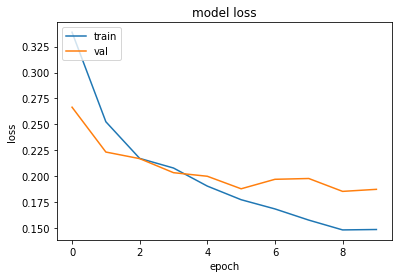

In [74]:
from matplotlib import pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [75]:
test_tokenized = tokenize(df_test[['TEXT',"CONTEXT"]],tokenizer)
y_test = np.asarray(df_test['LABEL'])

Evaluation


In [ ]:
from sklearn.metrics import classification_report

y_pred = model.predict(x=[test_tokenized[0],test_tokenized[1]], batch_size=64, verbose=1)
y_pred_bool = np.asarray([0 if i < 0.5 else 1 for i in y_pred ])

print(classification_report(y_test, y_pred_bool))

12/17 [====================>.........] - ETA: 13s

Hyperparameter Tuning Stage

In [ ]:
def build_model(hp):

  transformer_model =  TFAutoModel.from_pretrained("nlpaueb/bert-base-uncased-echr")

  input_ids_in = tf.keras.layers.Input(shape=(500,), name='input_token', dtype='int32')
  input_masks_in = tf.keras.layers.Input(shape=(500,), name='masked_token', dtype='int32') 

  embedding_layer = transformer_model(input_ids_in, attention_mask=input_masks_in)[0]
  cls_token = embedding_layer[:,0,:]
  X = tf.keras.layers.BatchNormalization()(cls_token)


  hp_units = hp.Int('units', min_value=32, max_value=512, step=64)
  
  X = tf.keras.layers.Dense(units=hp_units,activation='relu')(X)

  #hpdrop = hp.Float('units', min_value=0, max_value=0.3, step=0.1)
  X = tf.keras.layers.Dropout(0.2)(X)
  X = tf.keras.layers.Dense(1, activation='sigmoid')(X)
  model = tf.keras.Model(inputs=[input_ids_in, input_masks_in], outputs = X)


  

  hp_learning_rate = hp.Choice('learning_rate', values=[5e-6,5e-5,5e-4,1e-4,1e-5]) #try momentums

  optimizer = keras.optimizers.Adam(learning_rate=hp_learning_rate)

  model.compile(optimizer=optimizer,loss=tf.keras.losses.BinaryCrossentropy(),metrics=['accuracy',f1_m,recall_m])



  for layer in model.layers[:3]:
    layer.trainable = False
  return model

In [ ]:
!pip install keras_tuner
import keras_tuner
from tensorflow.keras import layers

In [ ]:
tuner = keras_tuner.Hyperband(build_model,
                     objective=keras_tuner.Objective('val_f1_m', direction='max'),
                    
                     overwrite=True,
                     metrics=[f1_m,recall_m,'accuracy'])

In [ ]:
tuner.search(x=[train_tokenized[0],train_tokenized[1]],y=y_train, validation_split=0.2) # display f1 as well
best_model = tuner.get_best_models()[0]

LSTM arch
